In [1]:
!pip3 install kaggle
!pip3 install pandas
!pip3 install matplotlib
!pip3 install torch
!pip3 install torchvision
!pip3 install scikit-learn
!pip3 install scikit-image
!pip3 install seaborn

# Kaggle setup

    On your Kaggle account, under API, select "Create New API Token" and kaggle.json will be downloaded on your computer.

    Go to directory — "${user.home}\.kaggle\" — and move here the downloaded JSON file.

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

k_api = KaggleApi()
k_api.authenticate()

# Handwritten Letters Dataset
### It contains the following info:
##### **The main dataset (letters.zip)**
1650 (50x33) color images (32x32x3) with 33 letters and the file with labels letters.txt.
Photo files are in the .png format and the labels are integers and values.
Additional letters.csv file.
The file LetterColorImages.h5 consists of preprocessing images of this set: image tensors and targets (labels).
##### **The additional dataset (letters2.zip)**
5940 (180x33) color images (32x32x3) with 33 letters and the file with labels letters2.txt.
Photo files are in the .png format and the labels are integers and values.
Additional letters2.csv file.
The file LetterColorImages2.h5 consists of preprocessing images of this set: image tensors and targets (labels).
##### **The additional dataset (letters3.zip)**
6600 (200x33) color images (32x32x3) with 33 letters and the file with labels letters2.txt.
Photo files are in the .png format and the labels are integers and values.
Additional letters3.csv file.
The file LetterColorImages3.h5 consists of preprocessing images of this set: image tensors and targets (labels).
Letter Symbols => Letter Labels
а=>1, б=>2, в=>3, г=>4, д=>5, е=>6, ё=>7, ж=>8, з=>9, и=>10,
й=>11, к=>12, л=>13, м=>14, н=>15, о=>16, п=>17, р=>18, с=>19, т=>20,
у=>21, ф=>22, х=>23, ц=>24, ч=>25, ш=>26, щ=>27, ъ=>28, ы=>29, ь=>30,
э=>31, ю=>32, я=>33

Image Backgrounds => Background Labels
striped=>0, gridded=>1, no background=>2, graph paper=>3

##### **The new version (zip_letters.zip)**
Letter Symbols => Letter Labels
а=>00, б=>01, в=>02, г=>03, д=>04, е=>05, ё=>06, ж=>07, з=>08, и=>09,
й=>10, к=>11, л=>12, м=>13, н=>14, о=>15, п=>16, р=>17, с=>18, т=>19,
у=>20, ф=>21, х=>22, ц=>23, ч=>24, ш=>25, щ=>26, ъ=>27, ы=>28, ь=>29,
э=>30, ю=>31, я=>32

'lowercase'=>00, 'uppercase'=>01

Image Backgrounds => Background Labels
'single-colored paper'=>00, 'striped paper'=>01, 'squared paper'=>02, 'graph paper'=>03



# Import the libraries and extract the dataset from zipped file.

In [57]:
from zipfile import ZipFile
import os
import shutil
from zipfile import ZipFile

os.makedirs('./.data', exist_ok = True)

if not os.path.exists('./.data/classification-of-handwritten-letters.zip'):
    #downloading datasets for ny stock exchange
    k_api.dataset_download_files(
        dataset='olgabelitskaya/classification-of-handwritten-letters',
        unzip=False
    )
    shutil.move('classification-of-handwritten-letters.zip', './.data')

    zf = ZipFile('./.data/classification-of-handwritten-letters.zip')
    zf.extractall('./.data/handwritten-letters/') 
    zf.close()

root_dir = './.data/handwritten-letters'
data_prefixes = ['letters', 'letters2', 'letters3']

letters_paths = [
    ('./.data/handwritten-letters/letters.csv', './.data/handwritten-letters/letters'),
    ('./.data/handwritten-letters/letters2.csv', './.data/handwritten-letters/letters2'),
    ('./.data/handwritten-letters/letters3.csv', './.data/handwritten-letters/letters3'),
]


# Import the dataset - 'letters.csv', 'letters2.csv', 'letters3.csv'

In [4]:
import pandas as pd

raw_dfs = []
for path in letters_paths:
    df = pd.read_csv(path[0])
    raw_dfs.append(df)
    

data_df = pd.concat(raw_dfs, axis=0)

# Perform EDA on the datsaet to understand the data.

## Number of labels

In [5]:
data_df['letter'].nunique()

33

## Number of samples by labels

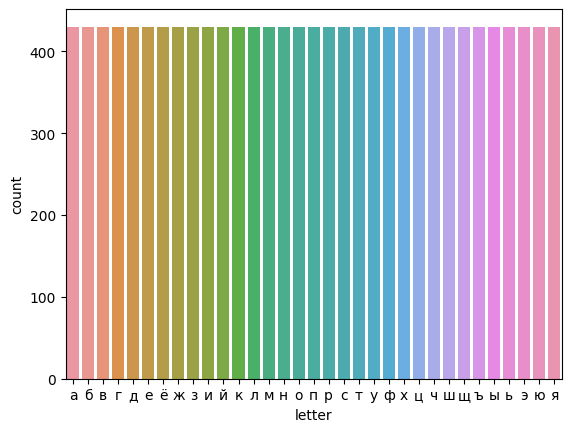

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=data_df, x='letter', orient='v')
plt.show()

## Number of backgrounds

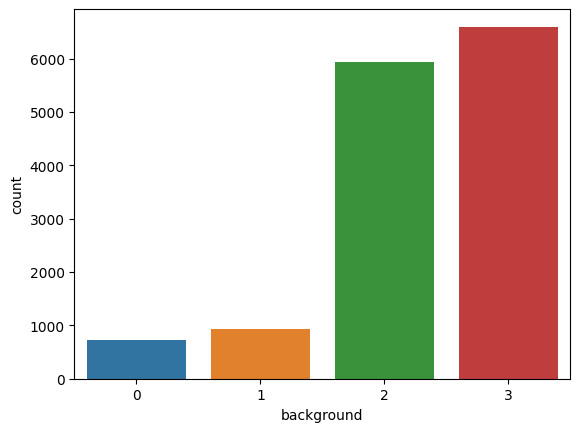

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


data_df["background"].nunique()

sns.countplot(data=data_df, x='background', orient='v')
plt.show()



# Extract the information to train the model from the dataset.

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

X = data_df[["background"]].to_numpy()

Y = data_df["label"].to_numpy()
Y = Y.reshape(-1, 1)

print(X.shape)
print(Y.shape)

(14190, 1)
(14190, 1)



# Train the CNN model.

## Define the model

In [65]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class CNet(nn.Module):
    def __init__(self, ignore_attr=False, verbose=0):
        super().__init__()
        self.verbose=verbose
        self.ignore_attr = ignore_attr
        self.cnn_stack = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, 
                kernel_size=3, stride=1, 
                padding=1
            ),
            #nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
            #nn.AdaptiveAvgPool2d(output_size=7),
            nn.Flatten()
        )
        
        attr_size = 0 if ignore_attr else 4
        cnn_out_size = 8
        cnn_out_dim = 32
        fc_input_dim = cnn_out_size*cnn_out_size*cnn_out_dim+attr_size
        self.fc_stack = nn.Sequential(
            # image size is 7X7 after conv. x 128 dimensions, +4 for attr
            nn.Linear(in_features=fc_input_dim, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            #nn.BatchNorm1d(128),
            nn.Linear(512, 33)
        )
    
    def forward(self, XImg, X):
        feats = self.cnn_stack(XImg)
        if self.verbose > 0:
            print("feats.shape", feats.shape, "X.shape", X.shape)
        all_feats = feats if self.ignore_attr else torch.cat((feats, X), dim=1) 
        if self.verbose > 1:
            print("all_feats -->", all_feats[0:3])
        logits = self.fc_stack(all_feats)
        return logits

Using cpu device


## Define datasets & data loaders

In [59]:
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import os
import numpy as np

class HandwrittenLettersDataset(Dataset):
    def __init__(self, root_dir=root_dir, prefixes=data_prefixes, img_size=32, img_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.prefixes = prefixes
        self.img_size = img_size
        self.img_transform = img_transform
        
        # 'single-colored paper'=>00, 'striped paper'=>01, 
        #   'squared paper'=>02, 'graph paper'=>03
        self.background_ohe = OneHotEncoder(
            categories=[[x for x in range(0, 4)]], 
            sparse_output=False, 
            dtype=float
        )
        
        dfs = []
        for path in self.prefixes:
            df = pd.read_csv(os.path.join(self.root_dir, path+'.csv'))
            dfs.append(df)
            df["img_dir"] = os.path.join(self.root_dir, path)
        self.data_frame = pd.concat(dfs, axis=0)
        self.letter_label = self.data_frame.groupby(["letter", "label"]).size().reset_index().drop(0, axis=1)
    
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = os.path.join(
            self.data_frame.iloc[idx]["img_dir"],
            self.data_frame.iloc[idx]["file"]
        )
        image = Image.open(img_path).convert('RGB')
        
        background = self.background_ohe.fit_transform(
            self.data_frame.iloc[idx][['background']].to_numpy().reshape(-1, 1)
        )[0]
        
        label = self.data_frame.iloc[idx][['label']].to_numpy()[0]
        
        if self.img_transform:
            image  = self.img_transform(image)
        
        sample = {
                  'image': image, 
                  'data': torch.from_numpy(background.astype(np.float32)), 
                  'label': label
                  }

        return sample
    
    

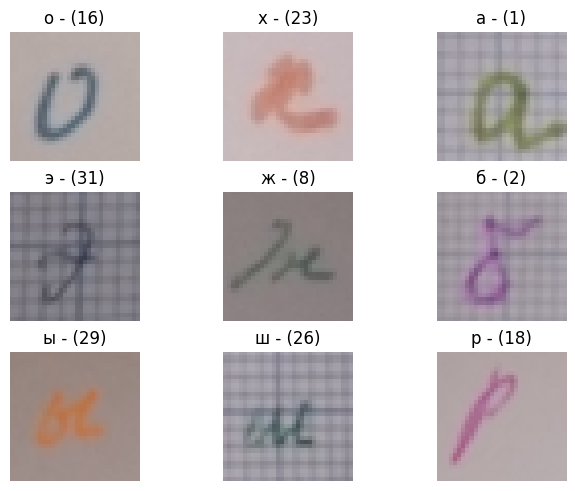

In [ ]:
import matplotlib.pyplot as plt
from numpy.random import randint
import numpy as np

lookup = letters_dataset.letter_label

num_images = 3

fig, axs = plt.subplots(num_images,num_images,
                        sharex=True,sharey=True,
                        layout='constrained')

idxs = randint(0, length, num_images*num_images)
for i in range(0, num_images):
    for j in range(0, num_images):
        item = letters_dataset.__getitem__(idxs[i*num_images+j])
        axs[i, j].imshow(np.moveaxis(item['image'].numpy(), 0, -1))
        title = lookup[lookup.label == item['label']]['letter'].values[0]
        title = title + ' - ('+str(item['label'])+')'
        axs[i, j].set_title(title)
        axs[i, j].axis('off')

plt.show()

In [48]:

from numpy.random import randint
import torchvision.transforms as transforms

def print_sample_size(i, sample):
    print(i, ": ", sample['image'].shape, sample['data'].shape, sample['label'])

transform = transforms.Compose(transforms=[
    transforms.Resize(32),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

letters_dataset = HandwrittenLettersDataset(img_transform=transform)
length = letters_dataset.__len__()
print(length)

print("label->", letters_dataset.__getitem__(0)['label'])
print("data->", letters_dataset.__getitem__(0)['data'].dtype)
print("data->", letters_dataset.__getitem__(0)['image'].dtype)

for i in randint(0, length, 10):
    print_sample_size(i, letters_dataset.__getitem__(i))

print("#labels", letters_dataset.letter_label["label"].nunique())

letters_dataset.letter_label.head(2)




14190
label-> 1
data-> torch.float32
data-> torch.float32
13657 :  torch.Size([3, 32, 32]) torch.Size([4]) 31
9354 :  torch.Size([3, 32, 32]) torch.Size([4]) 9
9575 :  torch.Size([3, 32, 32]) torch.Size([4]) 10
9424 :  torch.Size([3, 32, 32]) torch.Size([4]) 10
2646 :  torch.Size([3, 32, 32]) torch.Size([4]) 6
6140 :  torch.Size([3, 32, 32]) torch.Size([4]) 25
2228 :  torch.Size([3, 32, 32]) torch.Size([4]) 4
2505 :  torch.Size([3, 32, 32]) torch.Size([4]) 5
7790 :  torch.Size([3, 32, 32]) torch.Size([4]) 2
6964 :  torch.Size([3, 32, 32]) torch.Size([4]) 30
#labels 33


,letter,label
0,а,1
1,б,2


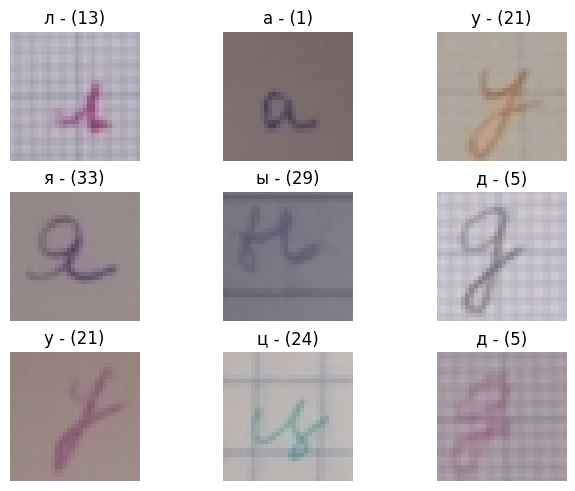

In [49]:
import matplotlib.pyplot as plt
from numpy.random import randint
import numpy as np

lookup = letters_dataset.letter_label

num_images = 3

fig, axs = plt.subplots(num_images,num_images,
                        sharex=True,sharey=True,
                        layout='constrained')

idxs = randint(0, length, num_images*num_images)
for i in range(0, num_images):
    for j in range(0, num_images):
        item = letters_dataset.__getitem__(idxs[i*num_images+j])
        axs[i, j].imshow(np.moveaxis(item['image'].numpy(), 0, -1))
        title = lookup[lookup.label == item['label']]['letter'].values[0]
        title = title + ' - ('+str(item['label'])+')'
        axs[i, j].set_title(title)
        axs[i, j].axis('off')

plt.show()

## Train the model

In [63]:
import torch

TRAIN_VERBOSE = 0

def accuracy(logits, Y_actual):
    Y_prob = torch.nn.functional.softmax(logits, dim=1)
    Y_pred = torch.argmax(Y_prob, dim=1)
    correct = Y_pred.eq(Y_actual.view_as(Y_pred)).sum().item()
    
    acc = correct / len(Y_actual)
    if TRAIN_VERBOSE > 1:
        print("logits", logits)
        print("Y_prob", Y_prob)
    if TRAIN_VERBOSE > 0:
        print("Y_pred", Y_pred)
        print("Y_actual", Y_actual)
        print("correct", correct)
        print("acc", acc)
    return correct
    

def train(model, train_data, criterion, optimizer):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    for d in train_data:
        XImg = d['image']
        X = d['data']
        Y = d['label']
        
        optimizer.zero_grad()
        logits = model(XImg, X)
        loss = criterion(logits, Y-1)
        
        loss.backward()
        optimizer.step()
        
        epoch_acc += accuracy(logits.detach(), Y-1)
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_data.dataset)
    epoch_acc /= len(train_data.dataset)
    
    return epoch_loss, epoch_acc

def test(model, test_data, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    for d in test_data:
        with torch.no_grad():
            XImg = d['image']
            X = d['data']
            Y = d['label']
            logits = model(XImg, X)
            loss = criterion(logits, Y-1)
            epoch_acc += accuracy(logits, Y-1)
            epoch_loss += loss.item()
    epoch_loss /= len(test_data.dataset)
    epoch_acc /= len(test_data.dataset)
    return epoch_loss, epoch_acc



In [28]:
import torch
sample_size = 10
ximg = torch.randn(sample_size, 4, 32, 32)
x = torch.randn(sample_size, 4)
y = torch.randint(33, (sample_size,), requires_grad=False)
y = y+1
print(torch.max(y))
print(ximg.shape, x.shape, y.shape)

class SampleDataset(Dataset):
    def __init__(self, ximg, x, y):
        self.ximg = ximg
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            'image': ximg[idx],
            "data": x[idx],
            'label': y[idx]
        }
        
sample_dl = DataLoader(SampleDataset(ximg, x, y), batch_size=4)
smodel = CNet(verbose=0)
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.RMSprop(smodel.parameters(), lr=0.01)
TRAIN_VERBOSE = 0
(train_loss, train_acc) = train(
    smodel, train_data=sample_dl, 
    criterion=loss_fn, optimizer=optim
)
print(train_loss)
print(train_acc)

tensor(25)
torch.Size([10, 4, 32, 32]) torch.Size([10, 4]) torch.Size([10])
692329.5124050856
0.0


In [61]:
import torch
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

transform = transforms.Compose(transforms=[
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = HandwrittenLettersDataset(img_transform=transform)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=123, shuffle=True)
print("train size", len(train_dataset), "test size", len(test_dataset))

batch_size = 64
train_data = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True, num_workers=0
)
test_data = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, 
    shuffle=True, num_workers=0
)

train size 9933 test size 4257


In [66]:
import torch

model = CNet(verbose=0, ignore_attr=True)
model

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
optim = torch.optim.Adam(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim, factor=0.1, patience=5, verbose=True
)

TRAIN_VERBOSE=0
epochs = 40
for epoch in range(1, epochs+1):
    train_loss, train_acc = train(model, train_data, loss_fn, optim)
    test_loss, test_acc = test(model, test_data, loss_fn)
    scheduler.step(train_loss)
    
    if epoch%10 == 0:
        print("Epoch", epoch, ":", 
                "train_loss", train_loss, 
                "train_acc", train_acc, 
                "test_loss", test_loss, 
                "test_acc", test_acc)

Epoch 10 : train_loss 0.17077689207801522 train_acc 0.9461391321856438 test_loss 0.6109431929674567 test_acc 0.8383838383838383
Epoch 20 : train_loss 0.0862233779749145 train_acc 0.9727172052753448 test_loss 0.7631810508425145 test_acc 0.8397932816537468
Epoch 00023: reducing learning rate of group 0 to 1.0000e-03.
Epoch 30 : train_loss 0.016674959336590408 train_acc 0.9961743682673915 test_loss 0.6050216862089566 test_acc 0.8740897345548508
Epoch 40 : train_loss 0.00862899653071257 train_acc 0.9979865096144166 test_loss 0.5975568866348894 test_acc 0.8792576932111816


# Plot the prediction vs true label to check the labels.